In [159]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [160]:
@jit(nopython=True)
# Function to initialize N positions randomly inside a unit circle
def initialize(N):
    p = []
    while len(p) < N:
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if x**2 + y**2 <= 1:
            p.append([x, y])
    return np.array(p)

In [161]:
@jit(nopython=True)
# Function to return a small perturbation
def perturb(sigma):
    k = np.random.normal(0, sigma)
    # if k > 0:
    #     return k
    # else:
    #     return k/10
    return  abs(np.random.normal(0, sigma))

In [162]:
@jit(nopython=True)
# Function to check whether particles are within a unit circle
def in_circle(p):
    return np.sum(p**2) <= 1

In [163]:
@jit(nopython=True)
# Function to calculate the energy of the system
def energy(p):
    E = 0
    for i in range(len(p)):
        for j in range(i+1, len(p)):
            E += 1/np.linalg.norm(p[i] - p[j])
    return E

In [164]:
@jit(nopython=True)
# Function to calculate the force on a particle
def force(p, i):
    f = np.zeros(2)
    for j in range(len(p)):
        if j != i:
            f += (p[i] - p[j]) / np.linalg.norm(p[i] - p[j])**3
    return f

In [165]:
@jit(nopython=True)
# Function to induce one perturbation on the system
def perturb_one(p, i, sigma):
        dir = force(p, i)/np.linalg.norm(force(p, i)) # Calculate direction of force

        p[i] += dir*perturb(sigma)
        
        if not in_circle(p[i]): # Check if perturbation is valid
            p[i] *= 1/np.linalg.norm(p[i]) # If not, move particle back to the edge of the circle
        return p

In [166]:
@jit(nopython=True)
# Function to induce perturbations on the system
def perturb_system(p, sigma):
    for i in range(len(p)):
        p[i] += perturb_one(p, i, sigma)
    return p

In [167]:
@jit(nopython=True)
# Function to calculate the acceptance probability
def acceptance_probability(E_old, E_new, T):
    if E_new < E_old:
        return 1
    else:
        return np.exp(-(E_new - E_old) / T)


In [168]:
@jit(nopython=True)
# Function to find new position of partcles
def new_positions(p, E, T, sigma):
    p_new = p.copy()
    E_new = E
    
    # Perturb the system
    for i in range(len(p)):
        p_trial = perturb_one(p_new, i, sigma)
        E_trial = energy(p_trial)

        # Check if perturbation is accepted
        if acceptance_probability(E_new, E_trial, T) > np.random.uniform(0, 1):
            p_new = p_trial
            E_new = E_trial
            
    return p_new, E_new

In [169]:
# Function to plot the positions of the particles
def plot_positions(p):
    fig, ax = plt.subplots()
    circle = plt.Circle((0, 0), 1, color='blue', fill=False)
    ax.add_artist(circle)
    ax.scatter(p[:,0], p[:,1], color='red', s=4)
    plt.xlim(-1.25, 1.25)
    plt.ylim(-1.25, 1.25)
    plt.axhline(y=0, color='blue')
    plt.axvline(x=0, color='blue')
    plt.title("Particle positions for N = " + str(len(p)))
    plt.show()

In [170]:
@jit(nopython=True)
# Function to run the annealing process
def annealing(N, T_max, T_min, cooling_schedule, no_iterations):
    # Initialize positions
    p = initialize(N)

    # Initialize energy
    E = energy(p)

    # Initialize temperature
    T = T_max

    # Initialize lists to store minima per temperature
    E_min_per_temp = [E]
    p_min_per_temp = [p]

    # Annealing process
    while T > T_min:
        #print("T: ", T) # Print temperature

        # Initialize standard deviation of random normal perturbation
        sigma = T /T_max

        # Initialize lists to store results per iteration
        E_iter = []
        p_iter = []

        # Markov chain
        for _ in range(no_iterations):
            # Get new positions for each iteration
            p, E = new_positions(p, E, T, sigma)
            #print("E: ", E)
            
            E_iter.append(E)
            p_iter.append(p)

        # Store minimum energy and corresponding positions for each temperature
        E_min_per_temp.append(min(E_iter))
        p_min_per_temp.append(p_iter[E_iter.index(min(E_iter))])
        
        #print("E min per temperature: ", E_min_per_temp[-1])
        #plot_positions(p_min_per_temp[-1])
        
        # Cool system
        T *= cooling_schedule

    return p_min_per_temp, E_min_per_temp    

E:  16.1333540967374


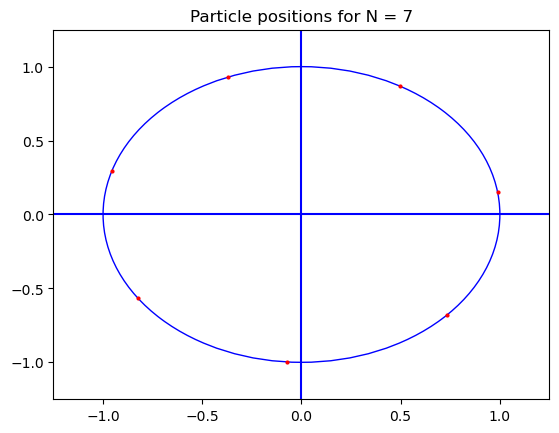

Min E:  16.1333540967374


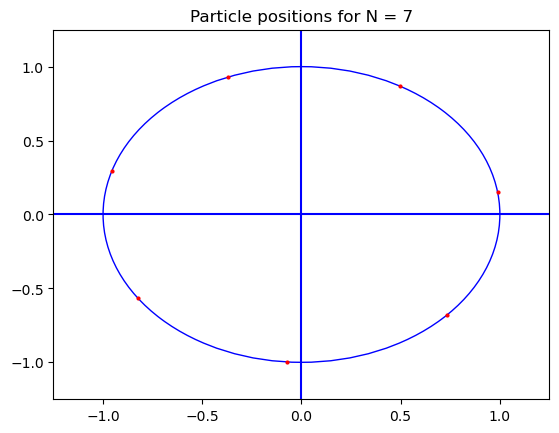

In [171]:
particles = 7
max_temp = 100
min_temp = 0.1
alpha = 0.99
iterations = 200

positions, energies = annealing(particles, max_temp, min_temp, alpha, iterations)
print("E: ", energies[-1])
plot_positions(positions[-1])

print("Min E: ", min(energies))
plot_positions(positions[energies.index(min(energies))])

